In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

### 1 The Momentum Product

(1) What is novel about the AQR Momentum product under construction compared to the various
momentum investment products already offered?

<span style="color:#00008B">**Solution:** The new product is a momentum mutual fund, and thus it will be available to retail investors rather than just those able to invest in hedge-funds.
To satisfy regulatory requirements, this implementation of momentum will be restricted to longonly
and to large stocks.</span>
   
   (2) Name three reasons the momentum investment product will not exactly track the momentum
index, (i.e. why the strategy will have tracking error.)

<span style="color:#00008B">**Solution:** There are many ways in which the fund might introduce tracking error as they try to minimize trading costs. Examples include, </span>
 - <span style="color:#00008B"> rebalancing at longer frequencies. (ie. quarterly vs monthly.)</span>
 - <span style="color:#00008B"> keeping stocks which technically no longer rank as momentum stocks but are deemed close enough. </span>
 - <span style="color:#00008B"> executing trades slowly so as to reduce price-impact and illiquidity. </span>
 - <span style="color:#00008B"> considering tax implications of the trades suggested by the momentum ranking and altering the portfolio construction accordingly. </span>
   
(3) When constructing the momentum portfolio, AQR ranks stocks on their returns from month
$t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?
   
<span style="color:#00008B">**Solution:** Market microstructure and liquidity issues cause prices reversion (not momentum!) in one-month returns. See footnote 2. </span>

### 2 Investigating Momentum

***1. Is momentum still profitable?***

The excess returns of lucrative trading strategies often disappear once the strategy is well-known.
The first widely-cited paper on momentum was published in 1993. Have momentum returns or
risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns
changed in 2009-2020?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

(a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{rmom:FF}$.

(b) Has momentum changed much over time, as seen through these subsample statistics?

(c) Does this data support AQR's argument that momentum is an important piece of the ideal
portfolio? What if mean returns to momentum are in actuality near zero due to transaction
costs - would there still be evidence here that momentum is valuable?

In [2]:
path = 'momentum_data-2.xlsx'
df_mom_size = pd.read_excel(path, sheet_name=4).set_index('Date')
df_factors = pd.read_excel(path, sheet_name=1).set_index('Date')
df_mom_size = df_mom_size.join(df_factors)

rf = pd.read_excel(path, sheet_name=5).set_index('Date')
df_mom_size = df_mom_size.join(rf)

df_momentum = pd.read_excel(path, sheet_name=3).set_index('Date')
df_momentum = df_momentum.join(rf)

In [3]:
#1 
df_mom_size['rx_mom_FF'] = (1/2 *(df_mom_size['BIG HiPRIOR'] + df_mom_size['SMALL HiPRIOR']) -
  1/2 * (df_mom_size['BIG LoPRIOR'] + df_mom_size['SMALL LoPRIOR'])) # same as UMD

In [4]:
df_mom_size['rx_mom_FF']

Date
1927-01-31    0.0036
1927-02-28   -0.0215
1927-03-31    0.0362
1927-04-30    0.0430
1927-05-31    0.0301
               ...  
2021-05-31    0.0088
2021-06-30    0.0224
2021-07-31   -0.0229
2021-08-31    0.0252
2021-09-30    0.0157
Name: rx_mom_FF, Length: 1137, dtype: float64

In [5]:
def table_row(df, portfolio, annualize_factor=12):
    mean = df[portfolio].mean() * annualize_factor
    vol = df[portfolio].std() * np.sqrt(annualize_factor)
    sharpe_ratio = mean/vol
    skew = df[portfolio].skew() #unscaled
    corr = df[[portfolio, 'MKT', 'HML']].corr()
    corr_to_mkt = corr.loc[portfolio, 'MKT']
    corr_to_value = corr.loc[portfolio, 'HML']
    return [mean, vol, sharpe_ratio, skew, corr_to_mkt, corr_to_value]


table1 = pd.DataFrame(index=['1927-2021', '1927-1993', '1994-2008', '2009-2021'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table1.loc['1927-2021', :] = table_row(df_mom_size.loc['1927':'2020',:], portfolio='rx_mom_FF')
table1.loc['1927-1993', :] = table_row(df_mom_size.loc['1927':'1993',:], portfolio='rx_mom_FF')
table1.loc['1994-2008', :] = table_row(df_mom_size.loc['1994':'2008',:], portfolio='rx_mom_FF')
table1.loc['2009-2021', :] = table_row(df_mom_size.loc['2009':'2020',:], portfolio='rx_mom_FF')
table1.style.set_caption('Solution Table 1: Momentum performance over time.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
1927-2021,0.0777,0.1634,0.4754,-3.0206,-0.3450,-0.4240
1927-1993,0.0902,0.1600,0.5635,-3.8084,-0.3623,-0.4960
1994-2008,0.1043,0.1756,0.5938,-0.5812,-0.2345,-0.1300
2009-2021,-0.0250,0.1648,-0.1519,-2.8264,-0.3832,-0.4626


<span style="color:#00008B">**Solution:**</span>

<span style="color:#00008B"> (a) See Solution Table 1, which gives stats of the monthly returns. (All but skewness are annualized.)</span>
 
<span style="color:#00008B"> (b) Momentum's performance has been fairly consistent over the entire sample
except that in the past 12 years the mean return has been very poor. This is driven mostly by the year 2009. Note that even in the final subsample the correlations to the market and value are close to their usual values, and the overall volatility is close to the usual.</span>

<span style="color:#00008B"> It's also noticeable that in the subperiod 1994-2008, the momentum has the best performance. The sharpe ratio is the highest, and the sknewness is only slightly negative. The correlations to the market and the value factor are the lowest. And this is exactly the period that momentum was published and well-practiced. </span>

<span style="color:#00008B"> (c) The persistent performance over time (except for the 2009 crash which causes low mean return in 2009-2020) seems to support the idea that momentum is not just a
statistical anomaly. Even in the final subsample, it gives negative correlation to the market
and value to the point it is valuable to a mean-variance investor even with a mean return
near zero.</span>

***2. The case is about whether a long-only implementation of momentum is valuable.***

Construct your own long-only implementation:,

$$ \tilde{r}^{momU:FF} = \frac{1}{2} \left( r^{momBU} + r^{momSU} \right) - r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This
would be very similar to a scaled version of,

$$ \tilde{r}^{momU} = \frac{1}{3} \left( r^{mom(8)} + r^{mom(9)} + r^{mom(10)} \right) - r^f $$

For the question below, use the FF-style, $\tilde{r}^{momU:FF}_t$.

(a) Fill out Table 2 for the data in the period 1994-2021.

(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility,
and Sharpe Ratio?

(c) Is long-only momentum as diversifying as long-short momentum with respect to market
and value premia?

(d) Show a plot of the cumulative product of $1 + \tilde{r}^{mom:FF}$ and $1 + \tilde{r}^{momU:FF}$ over the 2006-2021 subsample.

In [6]:
#2 
df_mom_size['rx_mom_U_FF'] = (1/2 * (df_mom_size['BIG HiPRIOR'] + df_mom_size['SMALL HiPRIOR']) -
    df_mom_size['RF'])

table2 = pd.DataFrame(index=['long_short', 'long_only'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table2.loc['long_short', :] = table_row(df_mom_size['1994':], portfolio='rx_mom_FF')
table2.loc['long_only', :] = table_row(df_mom_size['1994':], portfolio='rx_mom_U_FF')
table2.style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.0443,0.1708,0.2592,-1.4107,-0.3065,-0.2543
long_only,0.1237,0.1772,0.6979,-0.5019,0.9002,-0.1374


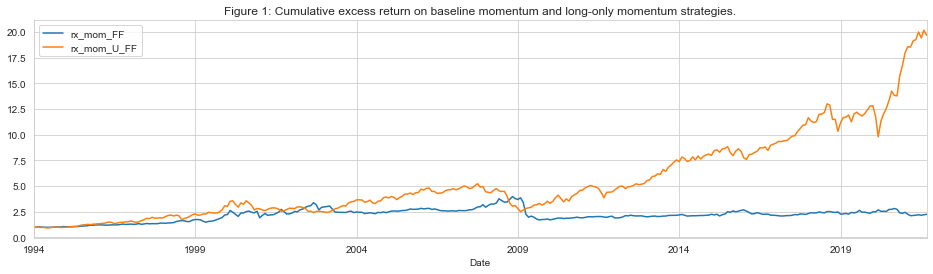

In [7]:
sns.set_style("whitegrid")
(df_mom_size.loc['1994':'2021', 'rx_mom_FF'] + 1).cumprod().plot(figsize=(16,4))
(df_mom_size.loc['1994':'2021', 'rx_mom_U_FF'] + 1).cumprod().plot(figsize=(16,4))
plt.title('Figure 1: Cumulative excess return on baseline momentum and long-only momentum strategies.')
plt.legend();

<span style="color:#00008B">**Solution:**</span>

<span style="color:#00008B"> (a) See Solution Table 2, which gives stats of the monthly returns. (All but skewness are annualized.) </span>
    
<span style="color:#00008B"> (b) During the period of 1994-2021, the mean, and Sharpe ratio are much higher in the long-only strategy, while the vol is about the same. It also has much less skewness. On these measures, it looks even more attractive. </span>
    
<span style="color:#00008B"> (c) The long-only strategy is extremely correlated with the market and thus should not be promoted based on its diversification to the market. The long-short strategy has
almost no market correlation and substantially negative correlation to value. </span>
    
<span style="color:#00008B"> (d) See Figure 1. From 1994 to 2021, the long-and-short momentum stratery only out-performed the long-only strategy in 2003 and 2009. There one sees that the long-and-short momentum strategy suffered massive losses in 2009, (roughly -80% return,) while the long-only strategy was down about 50%
in 2008 and up in 2009. This is a good illustration of the long-only strategy having less skewness. After 2009, the performance of long-and-short stratery was quite stable, and it has never returned to the previous level. On the other hand, the long-only strategy has recovered and soared after 2009. </span>

***3. Is momentum just data mining, or is it a robust strategy?***

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:
 - long the top 1 decile and short the bottom 1 deciles
 $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)} $$
 - long the top 3 deciles and short the bottom 3 deciles
 $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k=8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k=1}^{3} r^{mom(k)}$$
 - long the top 5 deciles and short the bottom 5 deciles
 $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k=6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k=1}^{5} r^{mom(k)}$$

(a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the
table below for the period 1994-2021.

(b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

(c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?

(d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that con- struction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [8]:
#3

df_momentum['rx_mom_D1'] = df_momentum['Hi PRIOR'] - df_momentum['Lo PRIOR']
table3 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

df = df_mom_size.join(df_momentum, rsuffix='momentum_')
df['rx_mom_D3'] = (1/3 * (df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/3 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3']))
df['rx_mom_D5'] = (1/5 * (df['PRIOR 6'] + df['PRIOR 7'] + df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/5 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3'] + df['PRIOR 4'] + df['PRIOR 5']))
table3.loc['rx_mom_D1', :] = table_row(df['1994':], portfolio='rx_mom_D1')
table3.loc['rx_mom_D3', :] = table_row(df['1994':], portfolio='rx_mom_D3')
table3.loc['rx_mom_D5', :] = table_row(df['1994':], portfolio='rx_mom_D5')

table3.style.set_caption('Table 3: Robustness of momentum construction.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
rx_mom_D1,0.0731,0.3018,0.2423,-1.3013,-0.3337,-0.2587
rx_mom_D3,0.0317,0.1947,0.1631,-1.3430,-0.3654,-0.2370
rx_mom_D5,0.0159,0.1354,0.1173,-1.4285,-0.3583,-0.2312


In [9]:
table2.style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.0443,0.1708,0.2592,-1.4107,-0.3065,-0.2543
long_only,0.1237,0.1772,0.6979,-0.5019,0.9002,-0.1374


<span style="color:#00008B">**Solution:**</span>

<span style="color:#00008B"> (a) See Table 3, which gives stats of the monthly returns. (All but skewness are annualized.) </span>
    
<span style="color:#00008B"> (b) The lecture implies that the more extreme the cutoff for the "winners", the higher the mean return of the momentum portfolio. The downside is that we would expect higher volatility.
This is consistent with what we see here. </span>

<span style="color:#00008B"> (c) If AQR can accept a higher volality and take on high concentrations in individual stocks, it can consider the 1-decile contruction as a retail product as the performance of the 1-decile construction is stronger. If AQR chooses the 5-decile construction, it means that it will hold all securities on the market, the trading costs from the rebalancing would be huge and the premium would be smaller too, but it has a smaller volality and a very diversified portfolio. I don't think AQR will choose either option. 
    
<span style="color:#00008B"> (d) The Fama-French construction has a larger mean, a smaller vol, and thus a higher sharpe ratio. Other measures are on the same scale as those of the 3-decile construction. This shows that segment by size actually gives a better performance. 


***4. Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?***

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,
 $$ \tilde{r}^{momS} = r^{momSU} - r^{momSD} $$
 
Similarly, use the data provided to construct a big-stock momentum portfolio,
 $$ \tilde{r}^{momB} = r^{momBU} - r^{momBD} $$

(a) Fill out Table 4 over the sample 1994-2021.

(b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?


In [10]:
#4
df['rx_mom_S'] = df['SMALL HiPRIOR'] - df['SMALL LoPRIOR']
df['rx_mom_B'] = df['BIG HiPRIOR'] - df['BIG LoPRIOR']
table4 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ','corr_to_v'])
table4.loc['rx_mom_FF', :] = table_row(df['1994':], portfolio='rx_mom_FF')
table4.loc['rx_mom_S', :] = table_row(df['1994':], portfolio='rx_mom_S')
table4.loc['rx_mom_B', :] = table_row(df['1994':], portfolio='rx_mom_B')
table4.style.set_caption('Table 4: Small stock momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_v
rx_mom_FF,0.0443,0.1708,0.2592,-1.4107,-0.3065,-0.2543
rx_mom_S,0.0577,0.1738,0.3321,-1.7289,-0.3093,-0.1925
rx_mom_B,0.0308,0.1837,0.1679,-0.8475,-0.2774,-0.2908


<span style="color:#00008B">**Solution:**</span>

<span style="color:#00008B"> It doesn't seem like the attractiveness of the momentum strategy is mostly driven by the small stocks as the all three momentum constructions have comparable performance. However, when taking the regulatory and liquidity issue into consideration, a momentum strategy in large stocks still delivers excess returns at comparable risk. 

#### 5 In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?
<span style="color:#00008B">**Solution:** The AQR retail product is substantially different from what we typically refer to as momentum. Though it has strong expected returns, it is almost all from market premium. This is a feature of being long-only and won't be fixed by modifying the exact constructions decile, sorting by size, etc. </span>